<a href="https://colab.research.google.com/github/NickBaynham/A3/blob/master/njb_ANN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description: Deep Neural Networks - Bank Churn Problem

## Background and Context
Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.
## Objective
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.
## Data Description
The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

### Data Dictionary
- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

# Reading the Dataset and Feature Elimination

This section includes loading the required libraries and the bank's customer churn sample set (representing randomly selected customer activity and characteristics over the previous six months).

## Importing the Required Packages for the Project

This section includes loading the required packages for the project.

In [ ]:
# Install Keras Tuner
!pip install -q -U keras-tuner

In [ ]:
# Ignore warnings so that the notebook will be tidy
import warnings
warnings.filterwarnings('ignore')

# Numerical, Statistical, and Visual Packages
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn ML Packages
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

# Tensorflow Packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential # Sequential is the easiest to learn
from tensorflow.keras.layers import Dense # Dense Layers are common in neural networks (fully-connected)
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt

# k-Fold Cross-Validation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dropout

In [ ]:
# Supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# Limit logging to informational messages
np.set_printoptions(threshold=np.inf)

## Reading the Dataset

Load the bank customer churn sample dataset to use as a basis for the project. I have saved the source data file to google drive for convenience.

In [ ]:
# The data will be read from the following google drive location
uri = 'https://drive.google.com/file/d/1kMX2eAuh__vBxPd1nmufMes4rGQWcl1z/view?usp=sharing'

In [ ]:
# Obtain the data provided for the project
file_id=uri.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
bank_data = pd.read_csv(dwn_url)
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


- The dataset was loaded successfully and matches the project data dictionary description.
- The dataset contains RowNumber, CustomerId, and Surname as sample identifiers - these should not be included in the statistical model as they do not add any value.
- Geography and Gender contain literal text as categorical data and will need to be encoded for statistical modelling.
- There's a wide variation in data values - such as the Balance variable which will require scaling of the data.
- The dependent variable Exited, IsActiveMember, HasCrCard, and Gender appear to be binary classifications.
- The variable we want to predict 'Exited' is binary, so the project is a binary classification problem.

In [ ]:
# Understand the shape of the data
print(bank_data.shape)

# Check for null values
bank_data.isna().any()

(10000, 14)


RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

The dataset consists of 10,000 rows of 14 columns. The data does not contain NaN values.

In [ ]:
bank_data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Observations
- Categorical and continous data columns are present
- The dependent variable is 'Exited' - this is the value we want to predict. 1 = a customer has churned, 0 = the customer has not churned.
- We are given 10,000 rows of 14 columns
- No NaN values appear in the dataset
- RowNumber and CustomerId are unique, whilst Surname is not.
- There are three geographical categorical values and two gender categorical values. Geographic values will need conversion to ordinals since there are more than two values possible
- NumOfProducts have four values that are possible, Gender, HasCrCard, and IsActiveMember have two possible values
- Exited has only two possible values and so the project can be treated as a binary classification problem.

## Feature Elimination

In this section, the RowNumber, CustomerId, and Surname variables will be dropped from the dataset as they are not needed for statistical modelling.

In [ ]:
# drop columns that will not add any value to the model and work with a copy of the dataset
data = bank_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

Since the variables RowNumber, CustomerId, and Surname contain no useful predictive information it will be safe to drop them from the study.

# Exploratory Data Analysis

In this section patterns and tendencies will be investigated in the sample dataset. First univariate analysis is performed, followed by bivariate analysis.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Geography and Gender contain literal text and represent categorical data and were provided as object data.

In [ ]:
# Convert objects to categories
columns = ['Geography', 'Gender']
data[columns] = data[columns].apply(lambda x: x. astype('category'))

Category type uses less memory and will be more efficient for visual analysis

In [ ]:
# Analyze the distributions in the sample dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


- Average credit score is ~650 in range 350 - 850
- Average age is ~39 in range 18 - 92 with expected outliers to the right
- Tenure average is ~5 in range 0 - 10
- Balance average is ~76k in range 0 - 250k with expected right outliers
- Number of products averages as ~2 in range 1 - 4
- ~71% of customers have a credit card
- ~52% of customers are active members
- ~100k average estimated salary in a range of ~51k - ~200k
- Only around 20% of customers have churned, so the bias of the sample is towards customers who have not churned in this analysis

In [ ]:
# Examine Value counts for a selection of variables
columns = ['Exited', 'Geography', 'Gender', 'NumOfProducts', 'Tenure', 'HasCrCard', 'IsActiveMember']
for x in columns:
  print(x)
  print(data[x].value_counts())

Exited
0    7963
1    2037
Name: Exited, dtype: int64
Geography
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Gender
Male      5457
Female    4543
Name: Gender, dtype: int64
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64
Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64
HasCrCard
1    7055
0    2945
Name: HasCrCard, dtype: int64
IsActiveMember
1    5151
0    4849
Name: IsActiveMember, dtype: int64


IsActiveMember, HasCrCard, Gender, and Exited are binary classifications.
Customers in the sample have a tendency to having only one or two products, a credit card, male, being active, in France and have not churned.

The Exited dependent variable has a large bias towards not exited. Most customers have a credit card. Active and non-active is about 50/50. Half the customers are from Franch and there are slightly more male customers. Customers tend to have fewer banking products on average.

## Univariate Visual Analysis

In this section, visual univariate analysis is considered.

We will now visually inspect each of the sample features individually.

In [ ]:
def pie_chart(data, dependent_variable, labels):
  sizes = [data[dependent_variable][data[dependent_variable]==1].count(), data[dependent_variable][data[dependent_variable]==0].count()]
  explode = (0, 0.1)
  fig1, ax1 = plt.subplots(figsize=(7, 6))
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')
  title = 'Proportion of ' + labels[0] + ' to ' + labels[1]
  plt.title(title, size = 15)
  plt.show()

In [ ]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Pie Chart: Customer Churn

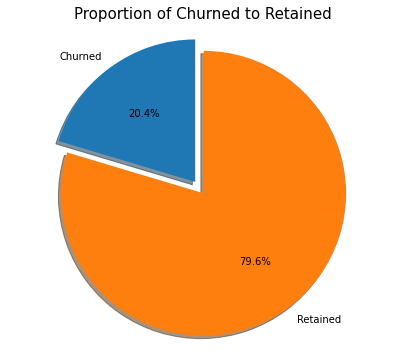

In [ ]:
labels = ['Churned', 'Retained']
pie_chart(data, 'Exited', labels)

Bank customer sample dataset shows a churn of 20.4%

For this project the focus should be on predicting that the 20.4% will churn - as the accuracy of this group is the most important to the bank. 

### Boxplot and Histogram: Customer Age

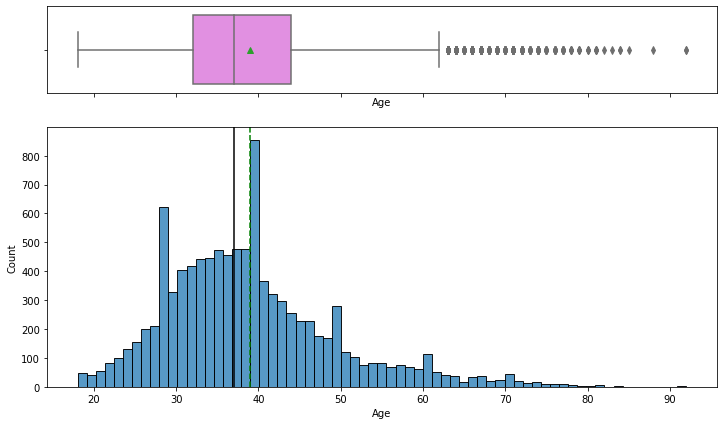

In [ ]:
# The distribution of the customer's age
histogram_boxplot(data, "Age")

The distribution of age is right-skewed with several outliers. There's no treatment needed, as this is an intuitively genuine age distribution for a bank. There seems to be age spikes before each decade which should be investigated, but possibly likely to approximations on some of the data - or perhaps the data is not random.

### Boxplot and Histogram: Credit Scores

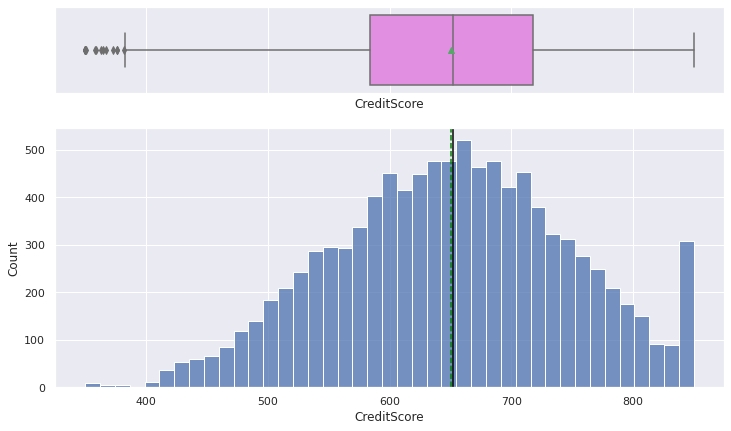

In [ ]:
# The distribution of customer credit scores
histogram_boxplot(data, "CreditScore")

The left outliers suggest that most customers have a credit score above 400. The scores are normally distributed except where some customers appear to have the maximum possible score. This distribution seems intuitively possible, the spike to the right indicating that many customers have a perfect score (the same highest possible score).

### Boxplot and Historgram: Tenure

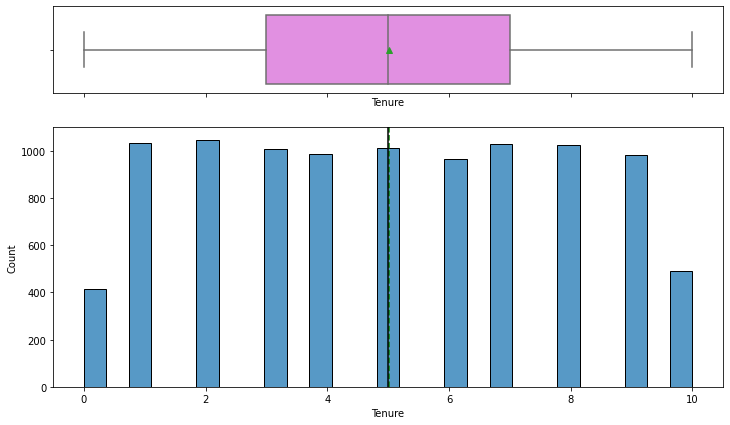

In [ ]:
# Distribution of Tenure
histogram_boxplot(data, "Tenure")

Tenure appears to be somewhat randomly distributed, although it is less likely a customer has 0 or 10. Intuitively I would suspect this feature is unreliable and suspect. We would expect that customer tenure would slope towards longer tenure but perhaps it is a symptom of the high churn rate.

### Boxplot and Histogram: Number of Products

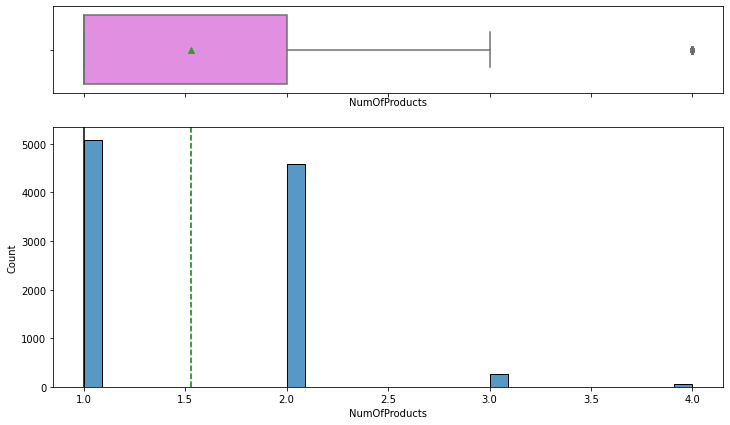

In [ ]:
# Distribution of the Number of Products
histogram_boxplot(data, "NumOfProducts")

We would expect customers to have at least one product (since by definition, that would preclude that they are a customer of the bank). It is extremely unlikely that a customer will have more than two products in the sample set. Having all four products is considered an extreme outlier according to the data. It may mean that most customers do not use these products or that they are being phased out.

### Boxplot and Histogram: Balance

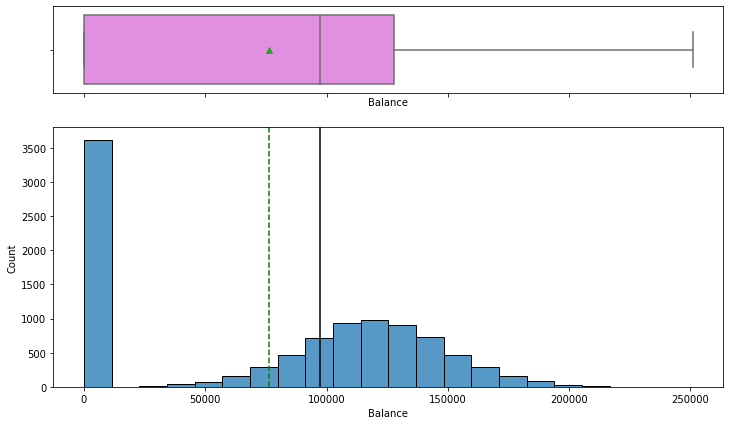

In [ ]:
# Distribution of Bank Balance
histogram_boxplot(data, 'Balance')

We see that around a third of the samples represent customers with a zero balance. This may correlate with customers that are not active. Of the customers that have a balance we see that the data is normally distributed with the mean around 100k. We have right outliers representing a minority of customers with a large balance up to 250k. This could be considered a bimodal distribution. It might be valuable to analyze churn on these two subsets of the samples separately in another study.

### Boxplot and Histogram: Estimated Salary

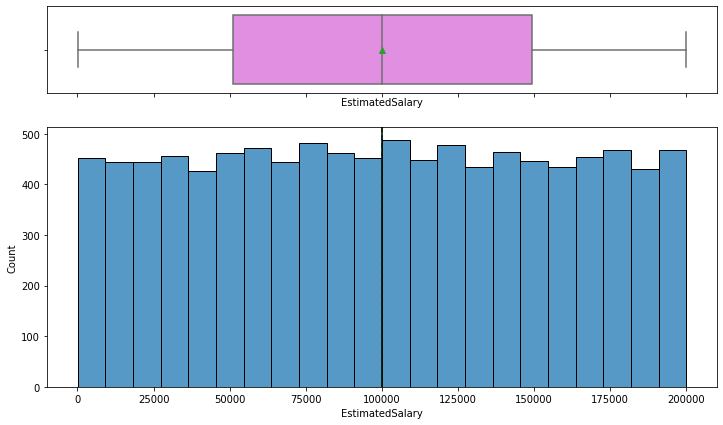

In [ ]:
# Distribution of Estimated Salary
histogram_boxplot(data, 'EstimatedSalary')

Estimated salary appears to be randomly distributed - or uniform across the range from 0 to 200k. Intuitively, this strikes me as unusual - we would expect to see a normally distributed salary across the population of bank customers. Perhaps the estimation is not that accurate. One way to check might be to look for a correlation of age to salary - which is known to correlate for many customer samples such as this one.

## Bivariate Analysis

In this section the relationships between features will be analyzed. This will give insight into whether or not the features will be useful in predicting churn and perhaps gleen some additional insights.

### Data Correlations

In [ ]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000,-0.004,0.001,0.006,0.012,-0.005,0.026,-0.001,-0.027
Age,-0.004,1.000,-0.010,0.028,-0.031,-0.012,0.085,-0.007,0.285
Tenure,0.001,-0.010,1.000,-0.012,0.013,0.023,-0.028,0.008,-0.014
Balance,0.006,0.028,-0.012,1.000,-0.304,-0.015,-0.010,0.013,0.119
NumOfProducts,0.012,-0.031,0.013,-0.304,1.000,0.003,0.010,0.014,-0.048
HasCrCard,-0.005,-0.012,0.023,-0.015,0.003,1.000,-0.012,-0.010,-0.007
IsActiveMember,0.026,0.085,-0.028,-0.010,0.010,-0.012,1.000,-0.011,-0.156
EstimatedSalary,-0.001,-0.007,0.008,0.013,0.014,-0.010,-0.011,1.000,0.012
Exited,-0.027,0.285,-0.014,0.119,-0.048,-0.007,-0.156,0.012,1.000


Churn seems to correlate somewhat with age, balance, and is active. 

Balance and the number of products has a strong negative correlation.

Correlations are weak overall for bivariates.

Interestingly age appears to negatively correlate with number of products, credit score, tenure, and estimate salary which is counter intuitive.


### Dependencies

In this section dependencies are analyzied between churn and the independent fatures provided in the sample dataset.

In [ ]:
# Analyze the dependency of a feature on another feature
def checkEffectOn(data, feature1, feature2):
  crosstab = pd.crosstab(
      data[feature1], data[feature2]
  )  # Contingency table of an independent variable and the dependent variable

  Ho = feature1 + " has no effect on " + feature2  # Stating the Null Hypothesis
  Ha = feature1 + " has an effect on " + feature2  # Stating the Alternate Hypothesis

  chi, p_value, dof, expected = stats.chi2_contingency(crosstab)

  if p_value < 0.05:  # Setting our significance level at 5%
      print(f"{Ha} as the p_value ({p_value.round(3)}) < 0.05")
  else:
      print(f"{Ho} as the p_value ({p_value.round(3)}) > 0.05")


In [ ]:
# Check if each feature has an effect on churn
features = ['Gender', 'EstimatedSalary', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

for X in features:
  checkEffectOn(data, X, 'Exited')

Gender has an effect on Exited as the p_value (0.0) < 0.05
EstimatedSalary has no effect on Exited as the p_value (0.492) > 0.05
CreditScore has an effect on Exited as the p_value (0.049) < 0.05
Age has an effect on Exited as the p_value (0.0) < 0.05
Tenure has no effect on Exited as the p_value (0.178) > 0.05
Balance has an effect on Exited as the p_value (0.0) < 0.05
NumOfProducts has an effect on Exited as the p_value (0.0) < 0.05
HasCrCard has no effect on Exited as the p_value (0.492) > 0.05
IsActiveMember has an effect on Exited as the p_value (0.0) < 0.05


Gender, Credit Score, Age, Balance, NumOfProducts, and IsActiveMember have an effect on churn.

### Stacked Bar Plot: Gender and Exited

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


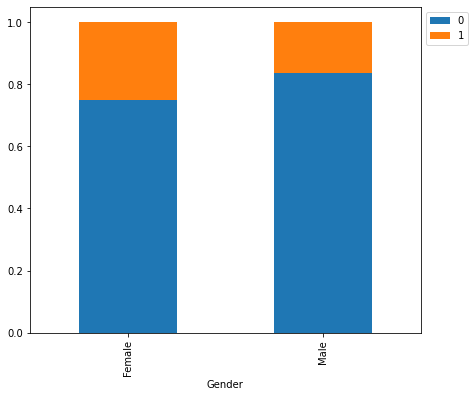

In [ ]:
stacked_barplot(data, 'Gender', "Exited")

Female customers have a higher tendency to churn. 

### Stacked Bar Plot: Credit Score and Exited

Exited          0     1    All
CreditScore                   
All          7963  2037  10000
850           190    43    233
651            33    17     50
705            37    16     53
637            32    14     46
...           ...   ...    ...
810             6     0      6
442             1     0      1
488            10     0     10
814            11     0     11
472             8     0      8

[461 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


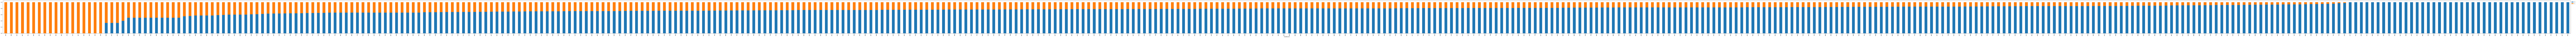

In [ ]:
stacked_barplot(data, 'CreditScore', 'Exited')

We can see visually the effect that credit score has on churn - the lower the credit score the higher the churn - with the lowest scores always churning. 

### Stacked Bar Plot: NumOfProducts and Exited

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


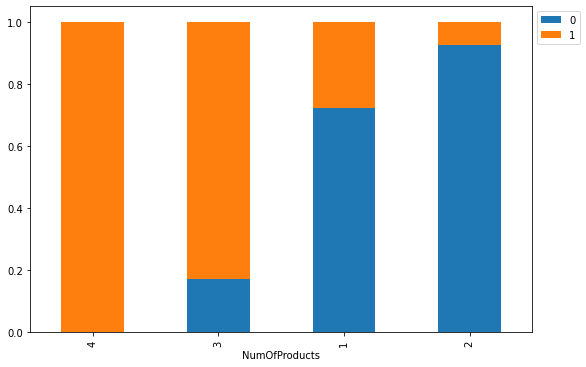

In [ ]:
stacked_barplot(data, 'NumOfProducts', 'Exited')

Customers with four products have a high tendency to churn. Customers with three products have the second highest.
Customers with one or two products are much less likely to churn. Customers with two products are the least likely to churn as predicted by the customer sample data.

### Stacked Bar Plot: Age and Exited

Exited     0     1    All
Age                      
All     7963  2037  10000
46       135    91    226
40       343    89    432
43       209    88    297
45       142    87    229
..       ...   ...    ...
79         4     0      4
78         5     0      5
77        10     0     10
76        11     0     11
75         9     0      9

[71 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


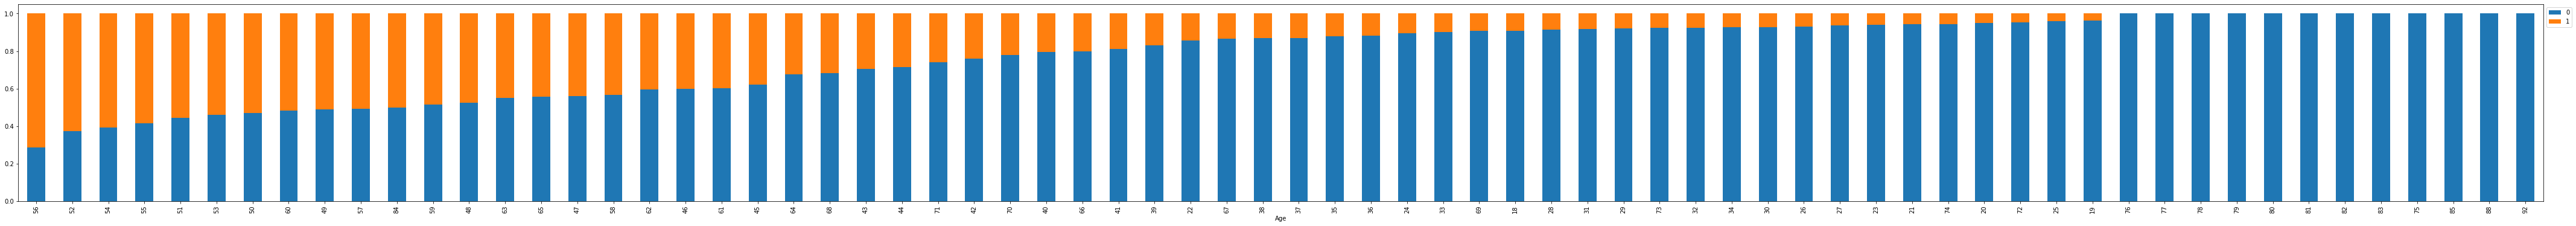

In [ ]:
stacked_barplot(data, 'Age', 'Exited')

Age appears to also be a strong predictor of churn. The younger the customer, the more likely.

### Stacked Bar Plot: Tenure and Exited

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


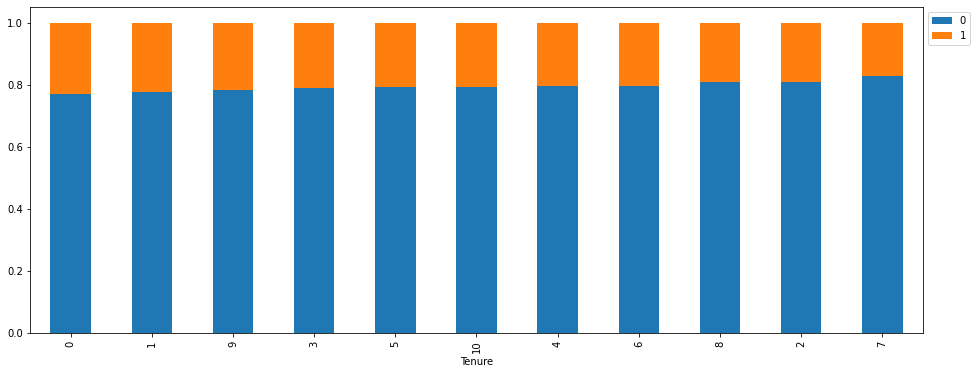

In [ ]:
stacked_barplot(data, 'Tenure', 'Exited')

Tenure appears to be a weak predictor in this analysis.

### Stacked Bar Plot: HasCrCard and Exited

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


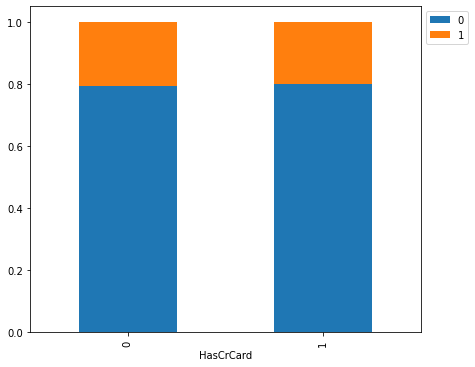

In [ ]:
stacked_barplot(data, 'HasCrCard', 'Exited')

Customers having a credit card or not does not appear to be a strong predictor.

### Stacked Bar Plot: IsActiveMember and Exited

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


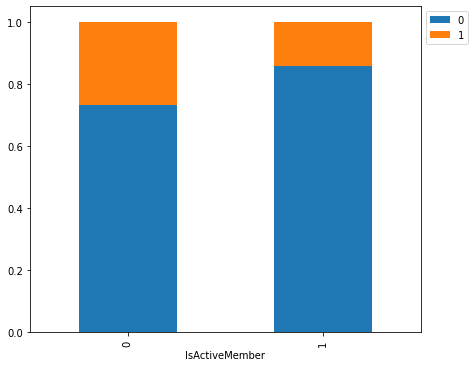

In [ ]:
stacked_barplot(data, 'IsActiveMember', 'Exited')

Inactive members are more likely to churn. This seems intuitive that customers that are not active would be more likely to change their services.

### Stacked Bar Plot: Geography

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


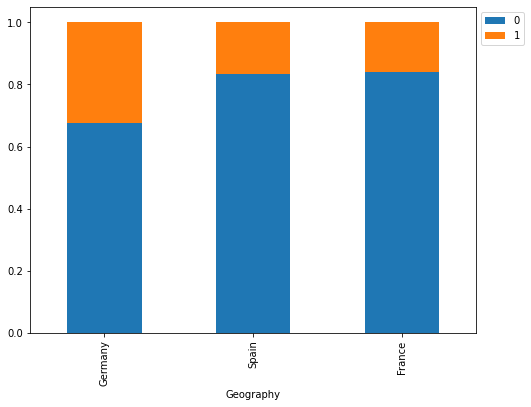

In [ ]:
stacked_barplot(data, 'Geography', 'Exited')

Customers in Germany are more likely to churn than Spain and France.

### Correlation Heat Map

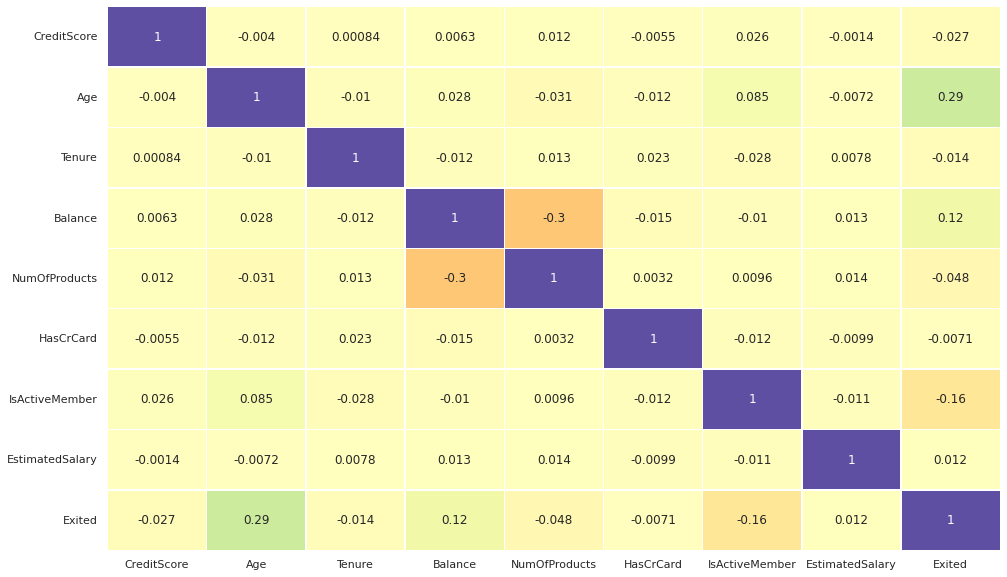

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

Balance and Number of products are negatively correlated. Age is postively correlated with churn. the heat map shows relatively weak correlations between features.

### Correlation Pairplot

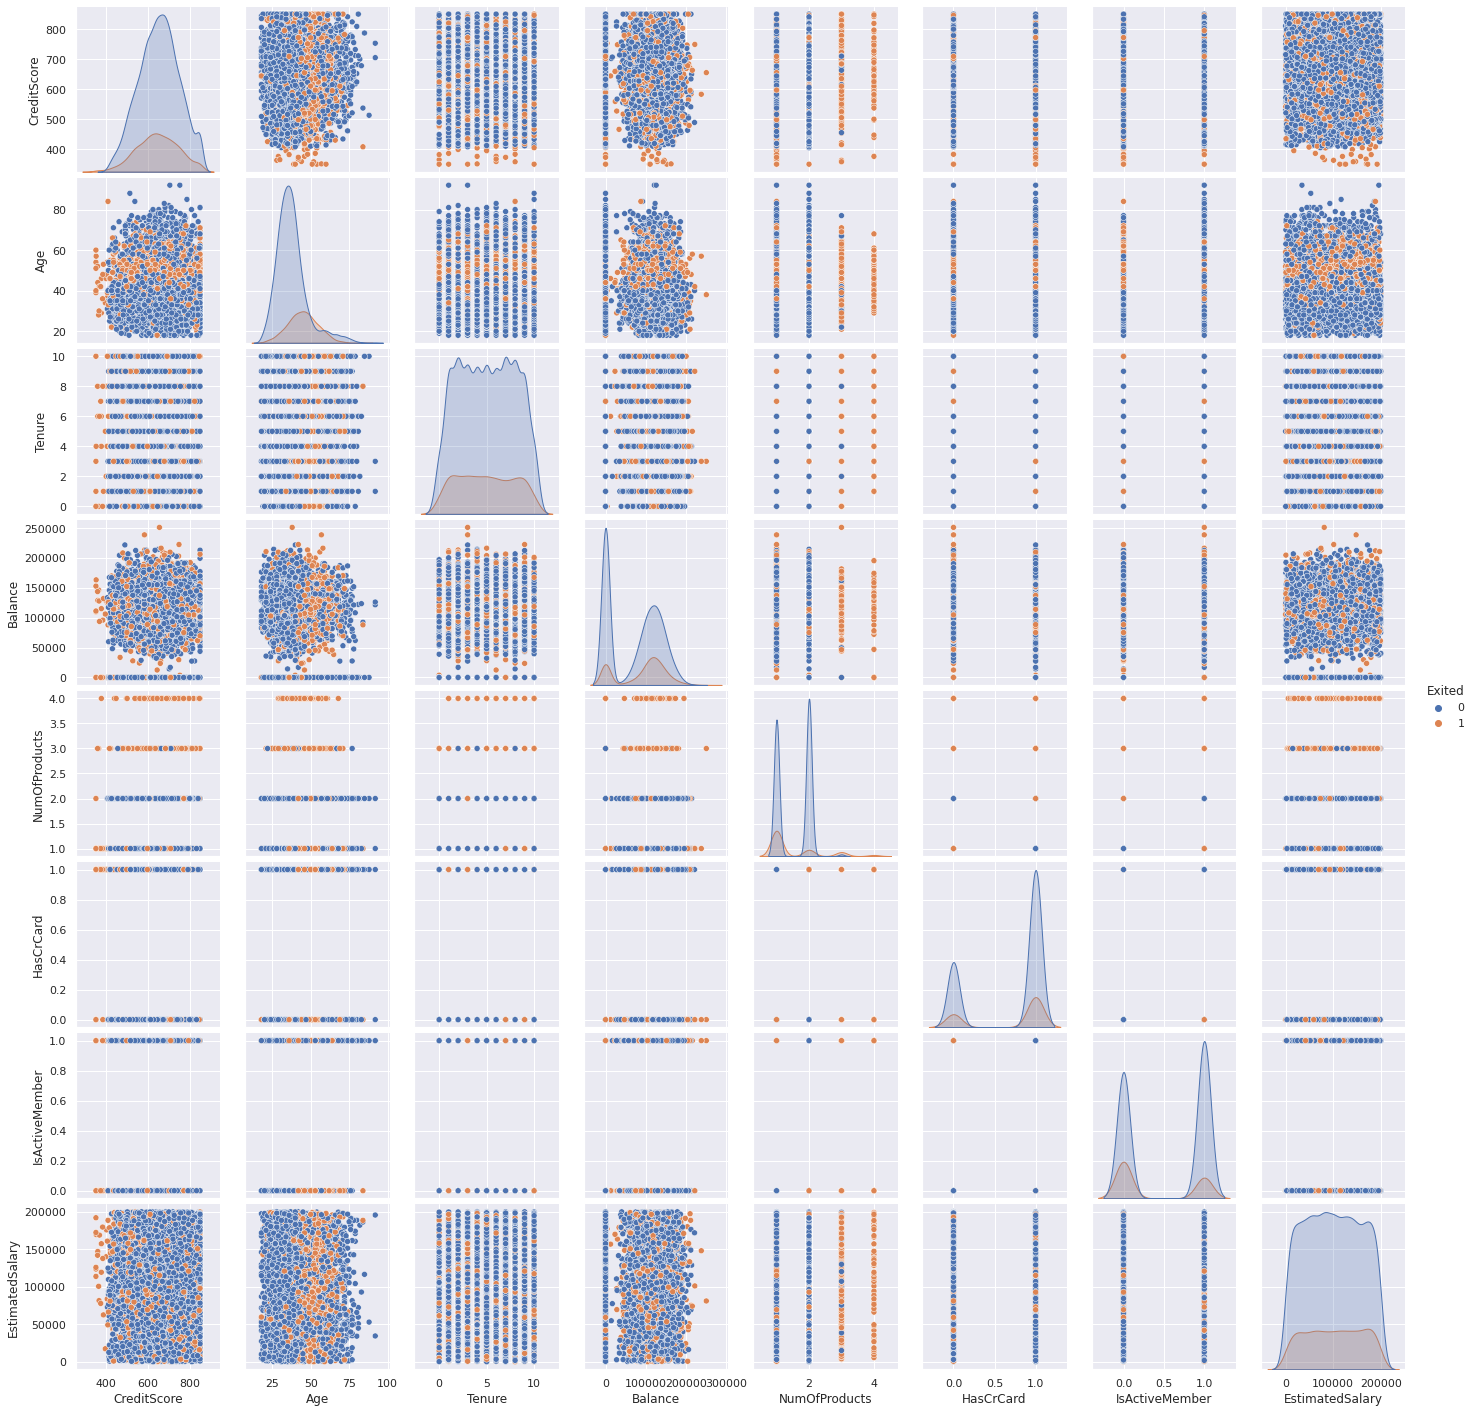

In [ ]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()
sns.pairplot(data=data[num_cols], diag_kind="kde", hue='Exited')
plt.show()

## Insights Based on EDA

- Customers in Germany are more likely to churn than the other countries. The bank should investigate why this is the case.
- Credit Score is a strong predictor of churn - customers with lower credit scores are more likely to churn with the lowest scores highly likely to churn.
- Customers with two products are less likely to churn. - Customers with more than two products have the highest likelihood of churn. The products that the bank is offering seems to be a factor.
- Statistical analysis shows us that the younger the customer, the more likely they are to churn. The bank should investigate why younger customers are more likely to churn.

We have seen that we have eight independent features to work with. We expect that Gender, Credit Score, Age, Balance, NumOfProducts, and IsActiveMember have an effect on churn and will be useful for statistical modelling and prediction. We have both categorical and continouous features, and the problem we are trying to solve is a binary classification problem with 1 indicating the customer has churned and 0 indicating the customer did not churn. Some of the categorical features are binary: Gender, HasCrCard, and IsActive. The bank is most interested in the accuracy of predicting that a customer is likely to churn as this will provide key information for further analysis and decision making.

## Data Pre-Processing

Before we can create our models we will need to transform the data so that it is handled correctly.

In [ ]:
# Separating target variable and other variables
X = data.drop(columns="Exited")
y = data["Exited"]
print(X.shape)
print(y.shape)
X.head()

(10000, 10)
(10000,)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.000,1,1,1,101348.880
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580
2,502,France,Female,42,8,159660.800,3,1,0,113931.570
3,699,France,Female,39,1,0.000,2,0,0,93826.630
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100


The independent variable, X now contains the independent features for the model, and y contains the dependent variable

In [ ]:
# Transform Geography and Gender
label_geography = LabelEncoder()
X['Geography'] = label_geography.fit_transform(X['Geography'])

label_gender = LabelEncoder()
X['Gender'] = label_gender.fit_transform(X['Gender'])
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.000,1,1,1,101348.880
1,608,2,0,41,1,83807.860,1,0,1,112542.580
2,502,0,0,42,8,159660.800,3,1,0,113931.570
3,699,0,0,39,1,0.000,2,0,0,93826.630
4,850,2,0,43,2,125510.820,1,1,1,79084.100


The Geography and Gender features were categorical and represented as literal text. Models require numerical data so we are converting the labels to numeric

In [ ]:
# One Hot Encoding

X = pd.get_dummies(X, drop_first=True, columns=['Geography'])
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_1,Geography_2
0,619,0,42,2,0.000,1,1,1,101348.880,0,0
1,608,0,41,1,83807.860,1,0,1,112542.580,0,1
2,502,0,42,8,159660.800,3,1,0,113931.570,0,0
3,699,0,39,1,0.000,2,0,0,93826.630,0,0
4,850,0,43,2,125510.820,1,1,1,79084.100,0,1


Since geography has three different categories we use one-hot encoding so that this ordinal variable is not taken as a continous variable.

We want to be able to train the model and then afterwards test the model for accuracy. We split the data into two datasets: train and test. 

In [ ]:
# Splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1, stratify = y
)

print(X_train.shape, X_test.shape)

(8000, 11) (2000, 11)


We reserve 20% of the data for testing the model and we will use the remaining 80% to train the model.

Using the ANN modelling approach we will need to scale our data. Each feature must be in a comparable range so as to accurately predict the binary classification.

In [ ]:
# Scale the training and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The testing and training data is scaled separately, so as to prevent information about the training data contaminating the test data, which should be completely independent.

## Model Building

We build an Artificial Neural Network based on the Sequential model. For activation I am choosing relu - which has shown to be one of the most successful activations. The input layer has the same number of neurons as the input X vector. For the hidden layer I am choosing 128 neurons. The output layer must be 1 neuron with sigmoid activation since it is a binary classifier. Note that the ANN model is Dense - which means all neurons in the previous layer are connected to all neurons in the next layer.


### Model 1

In [105]:
# Model 1
model = Sequential()
model.add(Dense(X.shape[1], activation='relu', input_dim = X.shape[1]))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
X.shape[1]

11

The weights will be initialized to random numbers close to zero by the Dense function. The features in the dataset are applied to each node in the input layer (input_dim).

In [106]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

We compile the model choosing to use the adam optimizer. Since we want binary classification we select the loss to be binary cross entropy. We want to measure performance by accuracy so we have selected the accuracy metric. Through forward propagation the output of the input layer is propagated to the hidden layer. Dense means that every output form the input neurons is an input to each of the hidden layer neurons. The rectifier activation function (relu) is the best available activator to determine the weights in the layers. The sigmoid activation in the output layer calculates the probabilities of each output class - in this case only two - a binary classification. If we had more than two output classes we would instead use the SoftMax activation function. The generated error (loss function or loss) is calculated by comparing the predicted value to the true (actual) value. The metric is the criteria we will use to evaluate the performance of the model. 

The calculated loss function is back-propagated and the weights are updated to reflect the influence. The learning rates will be the rate at which the weights are updated.

After iterating over the training set, and epoch has been run. We repeat for the number of epochs specified to continue training the model for the desired amount. The batch size hyper-parameter is set to determine the number of observations threshold must be reached before updating the weights.

In [107]:
history = model.fit(X_train, y_train.to_numpy(), validation_data = (X_test, y_test), batch_size = 20, epochs = 10, verbose = 1)

Epoch 1/10
400/400 [==============================] - 2s 3ms/step - loss: 0.6279 - accuracy: 0.6796 - val_loss: 0.4999 - val_accuracy: 0.7970
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4727 - accuracy: 0.7987 - val_loss: 0.4525 - val_accuracy: 0.8010
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4415 - accuracy: 0.8036 - val_loss: 0.4297 - val_accuracy: 0.8095
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.4215 - accuracy: 0.8145 - val_loss: 0.4109 - val_accuracy: 0.8230
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.3972 - accuracy: 0.8329 - val_loss: 0.3854 - val_accuracy: 0.8385
Epoch 6/10
400/400 [==============================] - 1s 2ms/step - loss: 0.3736 - accuracy: 0.8447 - val_loss: 0.3720 - val_accuracy: 0.8545
Epoch 7/10
400/400 [==============================] - 1s 2ms/step - loss: 0.3590 - accuracy: 0.8531 - val_loss: 0.3649 - val_accuracy: 0.8545
Epoch 

After training the model for 10 epochs, we see that on the training data the model achieved ~86% accuracy.

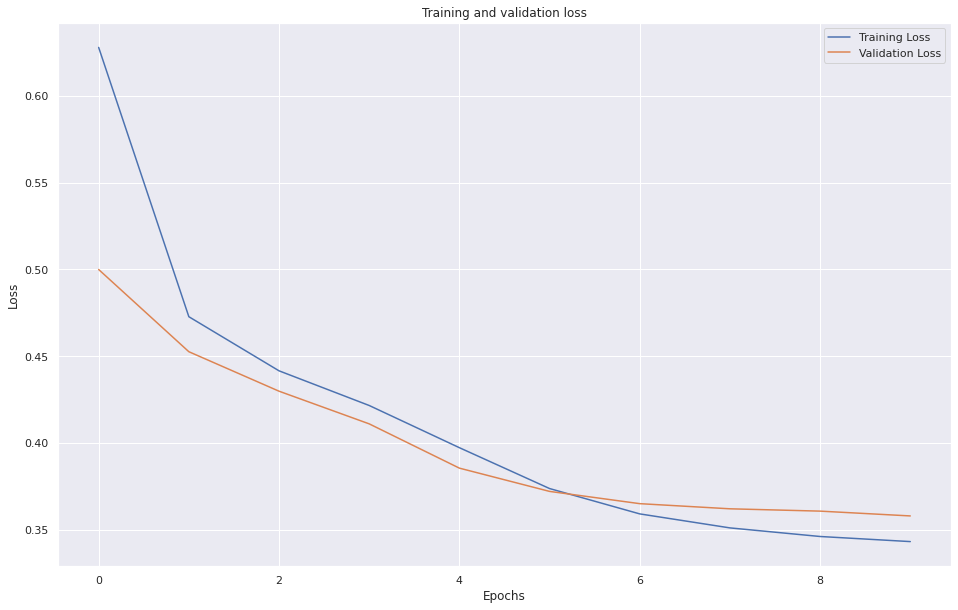

In [108]:
# Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model starts to overfit after six epochs.

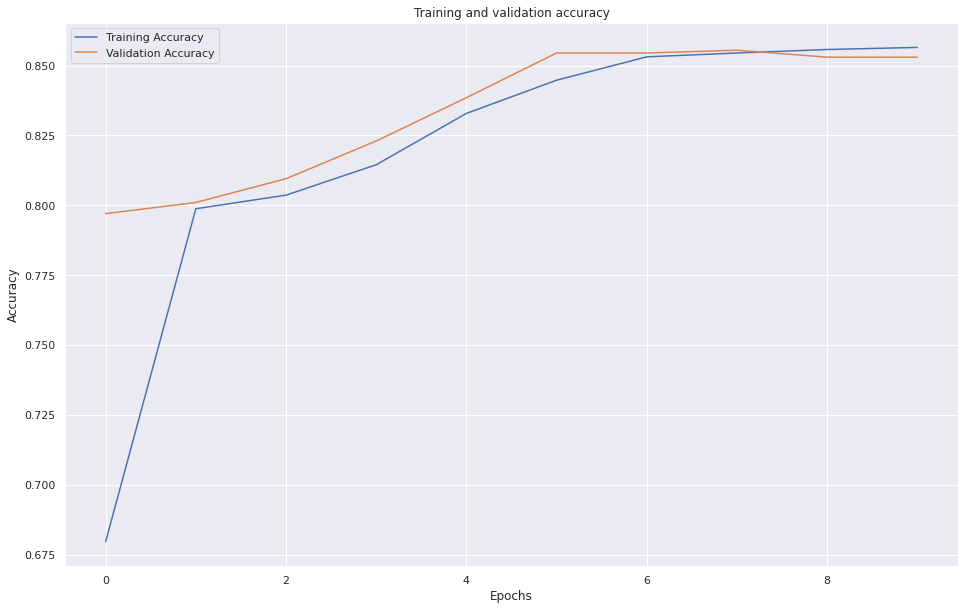

In [109]:
# Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The loss function starts to stabalize slow in rate of change around six epochs with slight overfitting.



In [110]:
# Evaluate model performance
model.evaluate(X_test, y_test.to_numpy())

63/63 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8530


[0.35784512758255005, 0.8529999852180481]

The ANN model has an accuracy of ~85.3% on the test data.

This section introduces model performance improvements. This is usually achieved by trying out different hyperparameters and re-training the model from scratch. For ANN we can try a combination of using different hyperparameters and reconfiguration of the hidden layers. We are using the same training and test data as before. A purely random classifier would reach an accuracy of 50% and we have so far achieved ~86%

### Model 2

In [112]:
## Model 2
model_2 = Sequential()
model_2.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model_2.add(Dense(3, activation='relu'))      # I am changing the configuration of the hidden layers here
model_2.add(Dense(2, activation='relu'))
model_2.add(Dense(1, activation = 'sigmoid'))

optimizer_2 = tf.keras.optimizers.Adam(0.001) # learning rate hyper-parameter is added here
epochs_2 = 50                                 # A larger number of epochs is added here

model_2.compile(optimizer=optimizer_2, loss = 'binary_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, batch_size = 64, validation_data = (X_test, y_test), epochs = epochs_2, verbose = 0)

In [113]:
model_2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3588 - accuracy: 0.8615


[0.3587910830974579, 0.8615000247955322]

On the test data the model scored ~86.2% accuracy - an improvement overall from the first model.

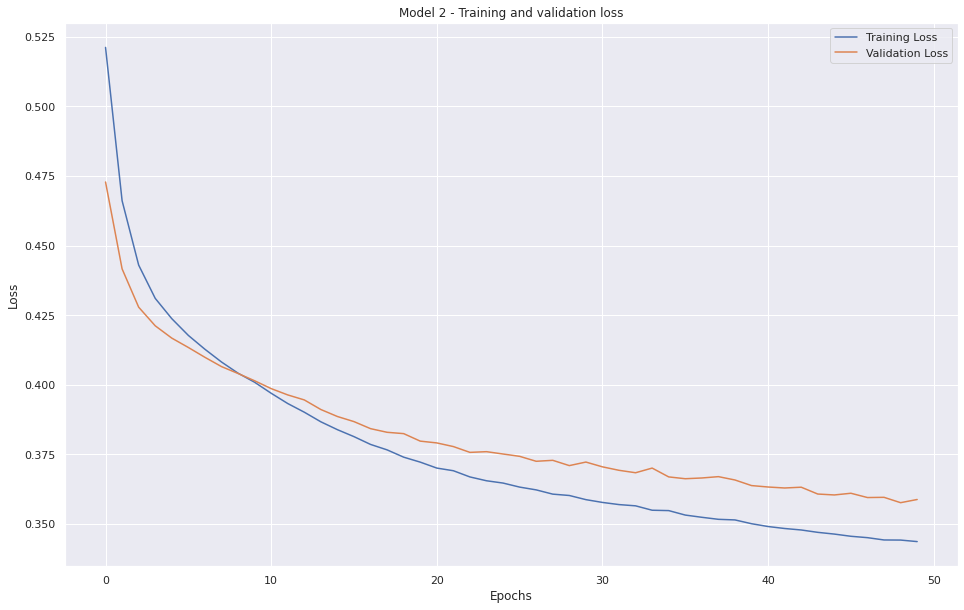

In [114]:
# Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history_2.history['loss'], label = 'Training Loss')
plt.plot(history_2.history['val_loss'], label = 'Validation Loss')
plt.title('Model 2 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see the validation curve crosses the test curve at 10 epochs and remains slightly above it.

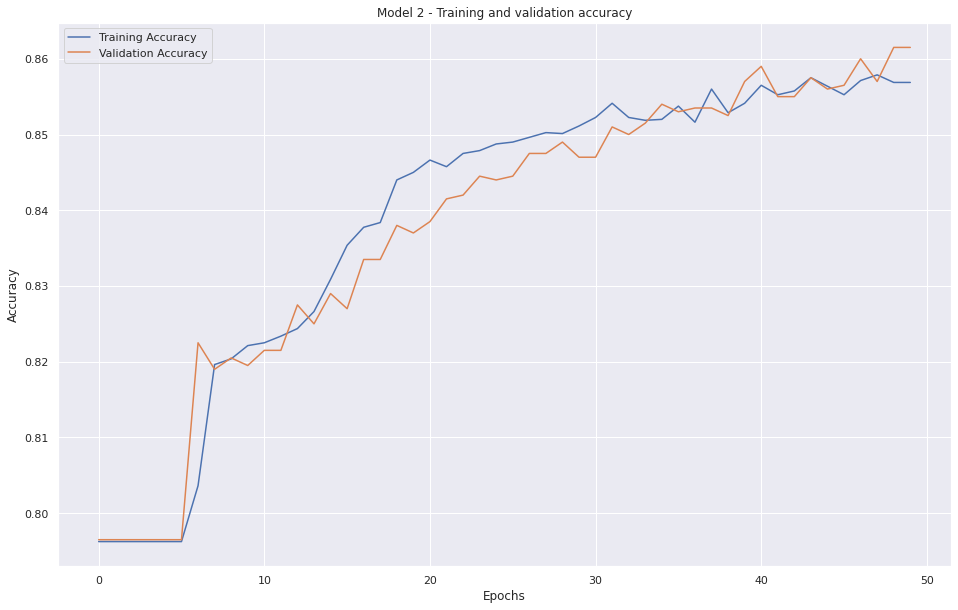

In [117]:
# Model 2 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_2.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 2 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training and Validation are performing very closely in model 2 for the accuracy vs epochs values.

In this section the tuned model performance will be evaluated.

In [118]:
# predict the churn values
ypred_2 = model_2.predict(X_test)

# unscale ypred
ypred_list_2 = []
for i in ypred_2:
  if i > 0.5:
    ypred_list_2.append(1)
  else:
    ypred_list_2.append(0)
print(ypred_list_2)

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

The predictions have been recoded to binary classifications

In [119]:
# create a dataframe of orignal and predict values
data_2 = {'orignal_churn':y_test, 'predicted_churn':ypred_list_2}
df_check_2 = pd.DataFrame(data_2)
df_check_2.head(10)

,orignal_churn,predicted_churn
4466,0,0
3754,0,0
9601,0,0
9758,0,1
8577,1,0
7795,0,1
2054,0,0
9226,0,0
9347,0,0
6850,0,0


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



Text(129.5, 0.5, 'True_number')

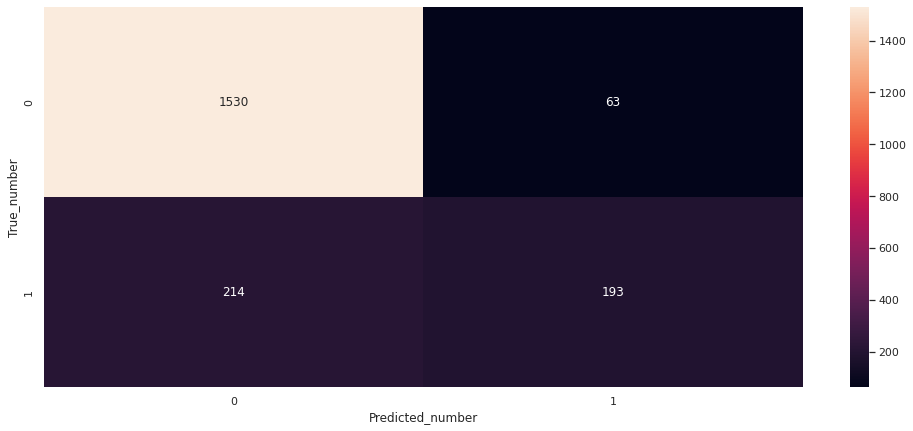

In [120]:
# print the classification_report for model 2
print(classification_report(y_test, ypred_list_2))

# plot the confusion metrix for model 2
conf_mat = tf.math.confusion_matrix(labels = y_test, predictions = ypred_list_2)
plt.figure(figsize = (17,7))
sbn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

We can see from the confusion matrix that out of a test sample set of 2,000 the model accurately predicted 1,530 + 193 correct predictions and 63 + 214 incorrect predictions.

### Model 3

In [125]:
# Model 3 - Tuning the ANN
model_3 = Sequential()
model_3.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model_3.add(Dropout(rate=0.1))           # I introduce the dropout rate to prevent overfitting
model_3.add(Dense(9, activation='relu')) # The hidden layer has more neurons than model 2
model_3.add(Dropout(rate=0.1))           # Another dropout rate is added here
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
epochs_3 = 50                            # Same as model 2 here - I'm using 50 epochs to train the model

In [126]:
# Train model 3 - I'm using a batch size of 54 (smaller than model 2)
history_3 = model_3.fit(X_train, y_train, batch_size = 54, validation_data = (X_test, y_test), epochs = epochs_3, verbose = 0)


In [127]:
model_3.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3522 - accuracy: 0.8535


[0.35221222043037415, 0.8535000085830688]

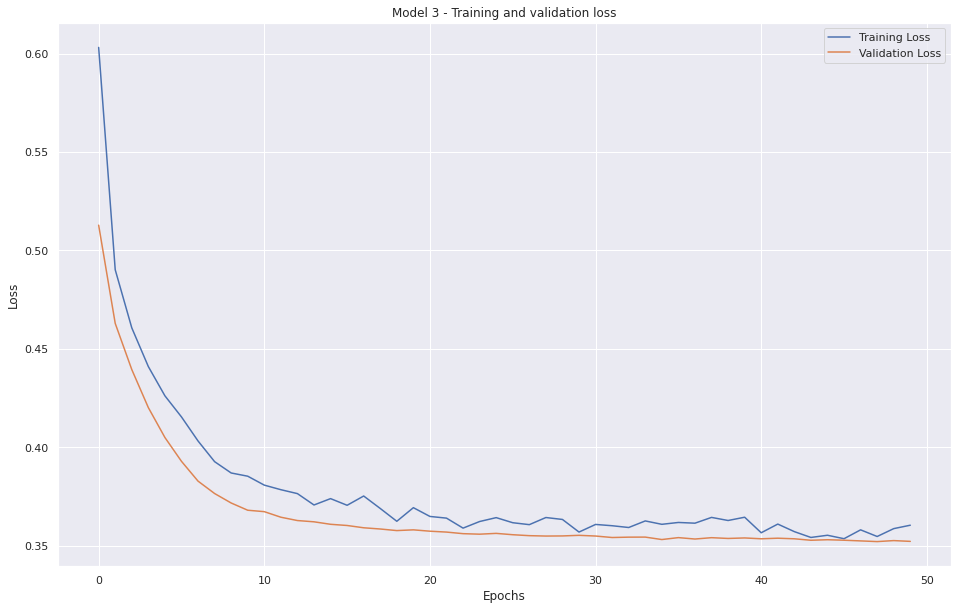

In [128]:
# Model 3 - Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history_3.history['loss'], label = 'Training Loss')
plt.plot(history_3.history['val_loss'], label = 'Validation Loss')
plt.title('Model 3 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

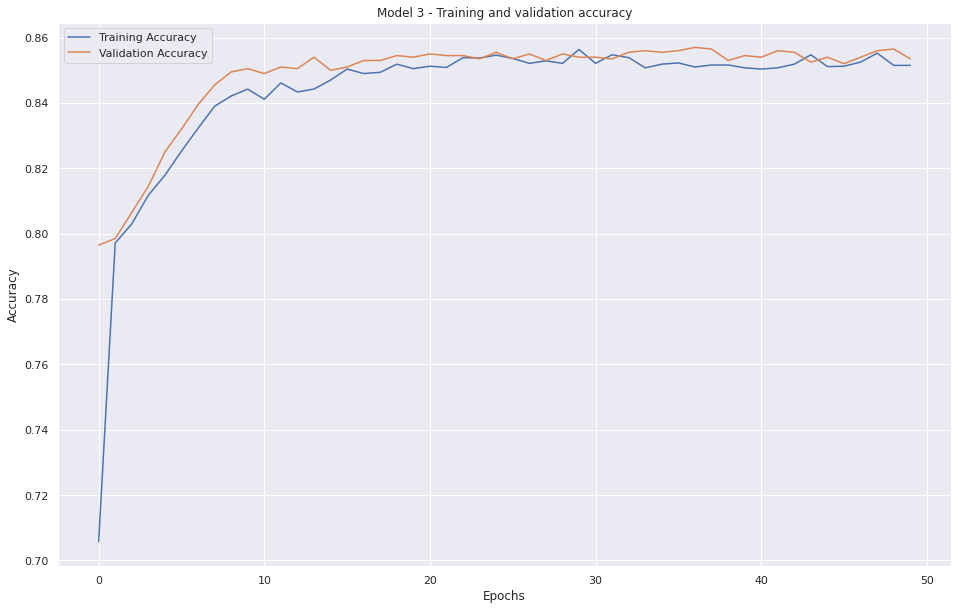

In [129]:
# Model 3 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_3.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 3 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [131]:
# Model 3 - predict the churn values
ypred_3 = model_3.predict(X_test)

# unscale ypred
ypred_list_3 = []
for i in ypred_3:
  if i > 0.5:
    ypred_list_3.append(1)
  else:
    ypred_list_3.append(0)
print(ypred_list_3)

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [132]:
# Model 3 - create a dataframe of orignal and predict values
data_3 = {'orignal_churn':y_test, 'predicted_churn':ypred_list_3}
df_check_3 = pd.DataFrame(data_3)
df_check_3.head(10)

,orignal_churn,predicted_churn
4466,0,0
3754,0,0
9601,0,0
9758,0,1
8577,1,0
7795,0,1
2054,0,0
9226,0,0
9347,0,0
6850,0,0


              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.78      0.39      0.52       407

    accuracy                           0.85      2000
   macro avg       0.82      0.68      0.72      2000
weighted avg       0.85      0.85      0.83      2000



Text(129.5, 0.5, 'True_number')

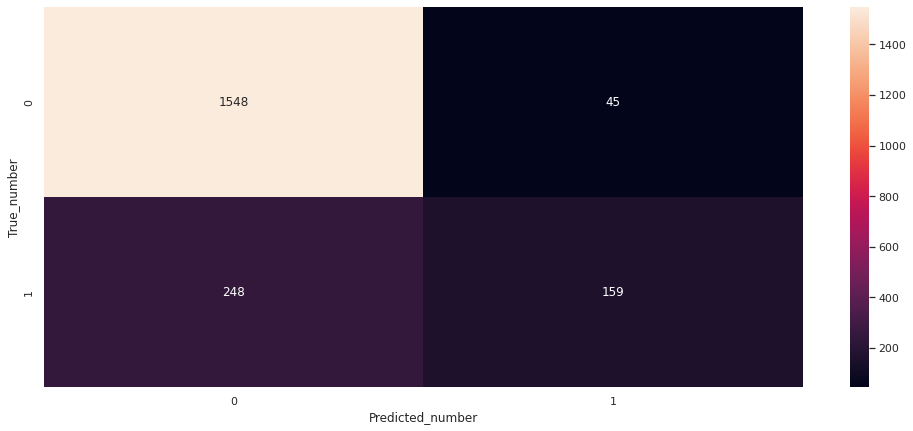

In [133]:
# Model 3 Confusion Matrix

# print the classification_report for model 3
print(classification_report(y_test, ypred_list_3))

# plot the confusion metrix for model 3
conf_mat = tf.math.confusion_matrix(labels = y_test, predictions = ypred_list_3)
plt.figure(figsize = (17,7))
sbn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

Model 3 achieves a recall of 97%

### Model 4

In [134]:
# Model 4 - Tuning the ANN
model_4 = Sequential()
model_4.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model_4.add(Dropout(rate=0.1))
model_4.add(Dense(3, activation='relu'))
model_4.add(Dropout(rate=0.1))
model_4.add(Dense(1, activation = 'sigmoid'))
model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
epochs_4 = 500

In [135]:
history_4 = model_4.fit(X_train, y_train, batch_size = 128, validation_data = (X_test, y_test), epochs = epochs_4, verbose = 0)


In [136]:
model_4.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8600


[0.34612223505973816, 0.8600000143051147]

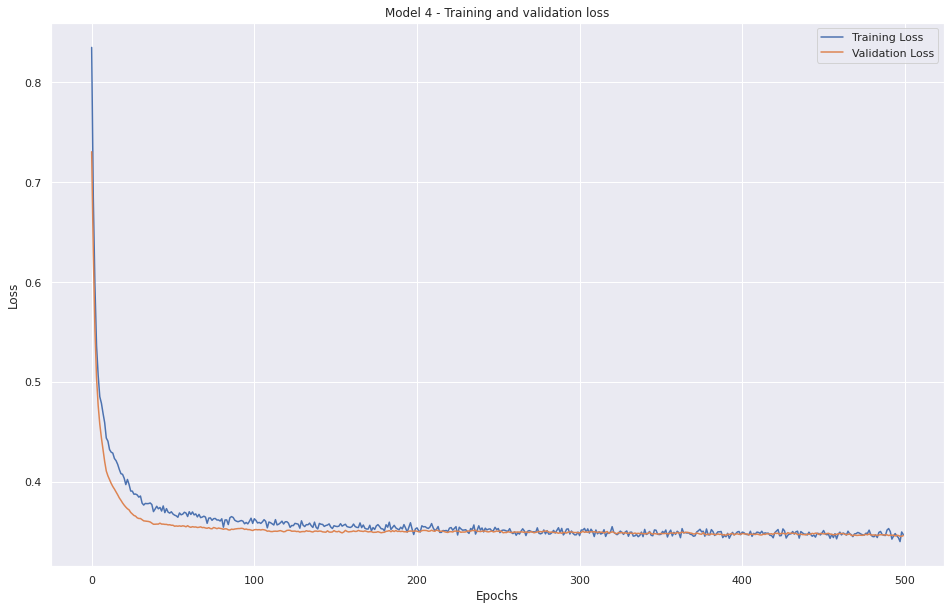

In [193]:
# Model 4 - Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history_4.history['loss'], label = 'Training Loss')
plt.plot(history_4.history['val_loss'], label = 'Validation Loss')
plt.title('Model 4 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

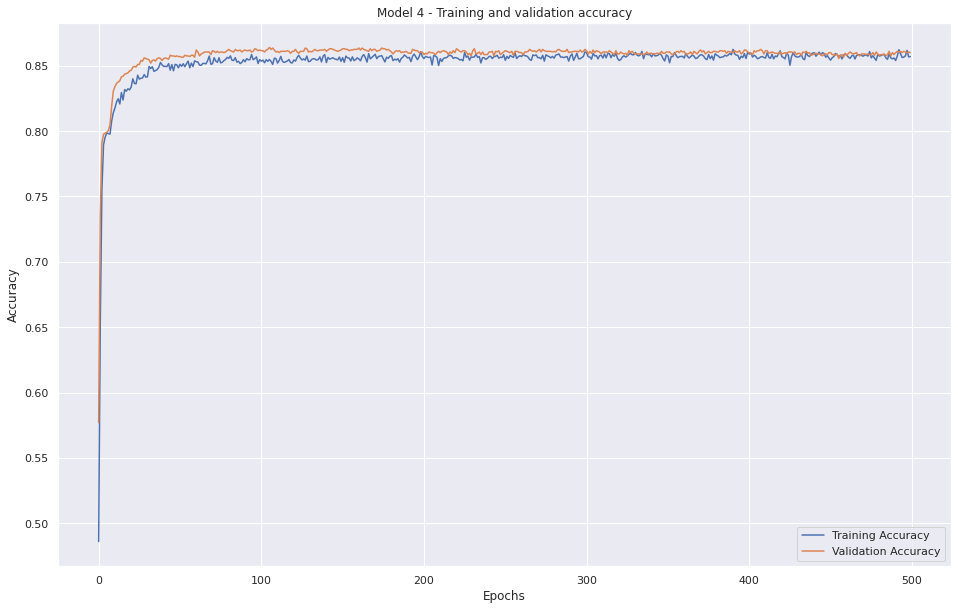

In [138]:
# Model 4 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_4.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 4 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [139]:
# Model 4 - predict the churn values
ypred_4 = model_4.predict(X_test)

# unscale ypred
ypred_list_4 = []
for i in ypred_4:
  if i > 0.5:
    ypred_list_4.append(1)
  else:
    ypred_list_4.append(0)   
print(ypred_list_4)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [140]:
# Model 4 - create the dataframe of the orignal and predict values
data_4 = {'orignal_churn':y_test, 'predicted_churn':ypred_list_4}
df_check_4 = pd.DataFrame(data_4)
df_check_4.head(10)

,orignal_churn,predicted_churn
4466,0,0
3754,0,0
9601,0,0
9758,0,0
8577,1,0
7795,0,1
2054,0,0
9226,0,0
9347,0,0
6850,0,0


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.81      0.41      0.54       407

    accuracy                           0.86      2000
   macro avg       0.84      0.69      0.73      2000
weighted avg       0.85      0.86      0.84      2000



Text(129.5, 0.5, 'True_number')

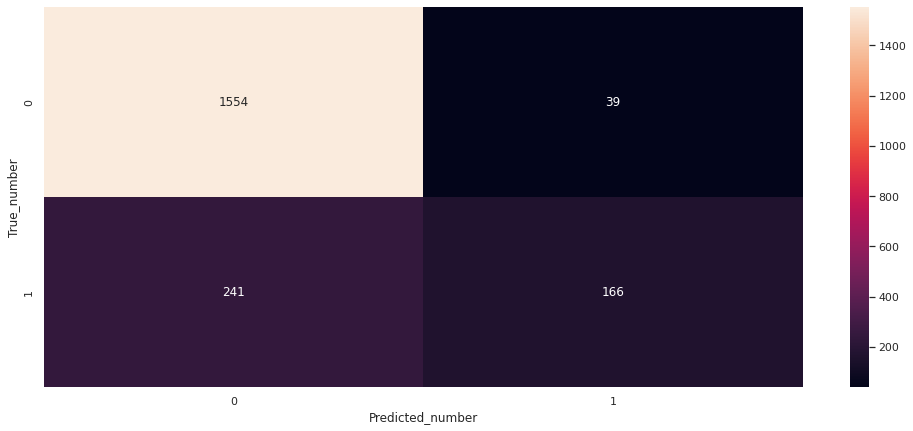

In [141]:
# Model 4 - Confusion Matrix
print(classification_report(y_test,ypred_list_4))

# ploting the confusion metrix plot
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=ypred_list_4)
plt.figure(figsize = (17,7))
sbn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

Model 4 achieves a recall of 98%

### Model 5

In [142]:
# Model 5
# Tuning the ANN
model_5 = Sequential()
model_5.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model_5.add(Dropout(rate=0.01))
model_5.add(Dense(3, activation='relu'))
model_5.add(Dropout(rate=0.01))
model_5.add(Dense(1, activation = 'sigmoid'))

optimizer_5 = tf.keras.optimizers.Adam(0.001) # learning rate hyper-parameter
model_5.compile(optimizer = optimizer_5, loss = 'binary_crossentropy', metrics=['accuracy'])

epochs_5 = 500
history_5 = model_5.fit(X_train, y_train, batch_size = 256, validation_data = (X_test, y_test), epochs = epochs_5, verbose = 0)

model_5.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3503 - accuracy: 0.8565


[0.3503280282020569, 0.8565000295639038]

In [143]:
# Model 5 - predict the churn values
ypred_5 = model_5.predict(X_test)

# unscale ypred
ypred_list_5 = []
for i in ypred_5:
  if i > 0.5:
    ypred_list_5.append(1)
  else:
    ypred_list_5.append(0)   
print(ypred_list_5)

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [144]:
# Model 5 - create the dataframe of the orignal and predict values
data_5 = {'orignal_churn':y_test, 'predicted_churn':ypred_list_5}
df_check_5 = pd.DataFrame(data_5)
df_check_5.head(10)

,orignal_churn,predicted_churn
4466,0,0
3754,0,0
9601,0,0
9758,0,1
8577,1,0
7795,0,1
2054,0,0
9226,0,0
9347,0,0
6850,0,0


              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.45      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



Text(129.5, 0.5, 'True_number')

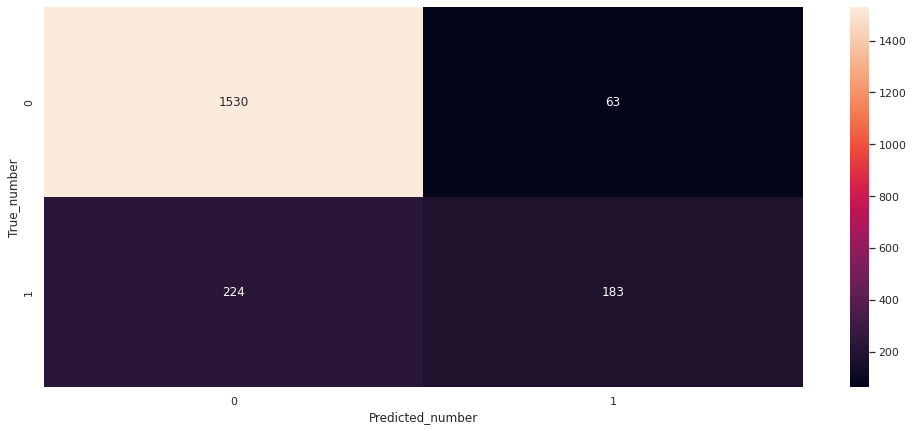

In [145]:
# Model 5 - Confusion Matrix
print(classification_report(y_test,ypred_list_5))

# ploting the confusion metrix plot
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=ypred_list_5)
plt.figure(figsize = (17,7))
sbn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

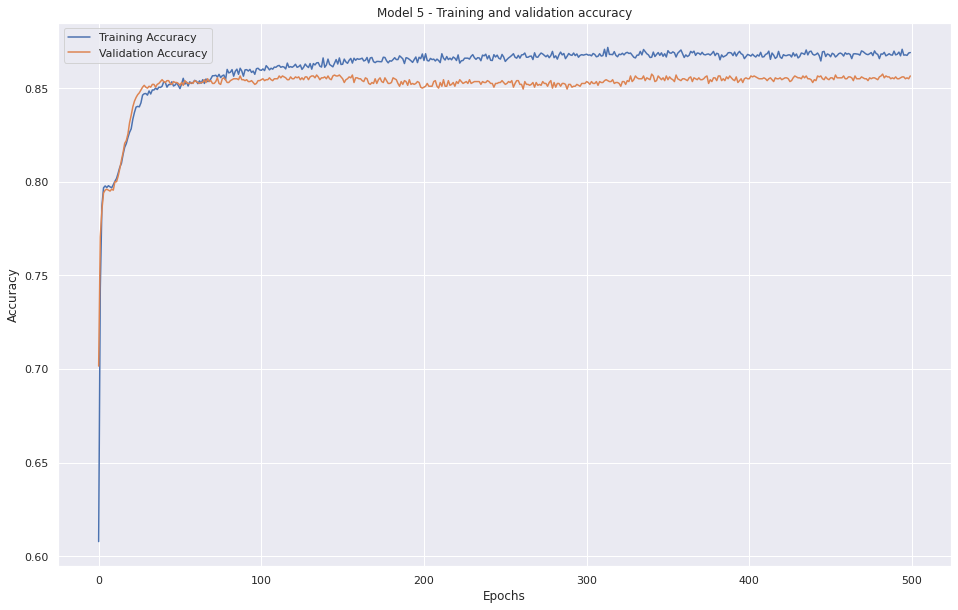

In [146]:
# Model 5 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_5.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 5 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model can predict churn with 86.3% accuracy on the reserved test data. We saw in the confusion matrix that 274 samples were predictied incorrectly out of a total of 2,000 samples. An F1 Score of 92% was achieved predicting a customer will not churn.

### Model 6

In [147]:
# Model 6
# Tuning the ANN
model_6 = Sequential()
model_6.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model_6.add(Dense(3, activation='relu'))
model_6.add(Dense(1, activation='relu'))
model_6.add(Dense(1, activation = 'sigmoid'))

optimizer_6 = tf.keras.optimizers.Adam(0.001) # learning rate hyper-parameter
model_6.compile(optimizer = optimizer_6, loss = 'binary_crossentropy', metrics=['accuracy'])

epochs_6 = 250
history_6 = model_6.fit(X_train, y_train, batch_size = 128, validation_data = (X_test, y_test), epochs = epochs_6, verbose = 0)
model_6.evaluate(X_train, y_train)
model_6.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3505 - accuracy: 0.8640


[0.3504786491394043, 0.8640000224113464]

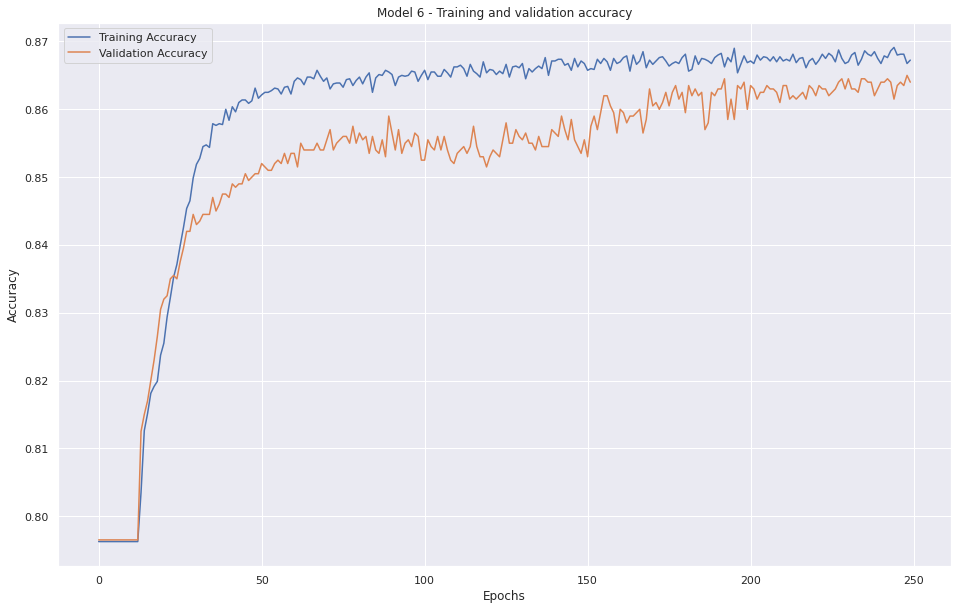

In [148]:
# Model 6 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_6.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_6.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 6 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [149]:
# Model 6 - predict the churn values
ypred_6 = model_6.predict(X_test)

# unscale ypred
ypred_list_6 = []
for i in ypred_6:
  if i > 0.5:
    ypred_list_6.append(1)
  else:
    ypred_list_6.append(0)   
print(ypred_list_6)

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

In [150]:
# Model 6 - dataframe for comparing the orignal and predict values
data_6 = {'orignal_churn':y_test, 'predicted_churn':ypred_list_6}
df_check_6 = pd.DataFrame(data_6)
df_check_6.head(10)

,orignal_churn,predicted_churn
4466,0,0
3754,0,0
9601,0,0
9758,0,1
8577,1,0
7795,0,1
2054,0,0
9226,0,0
9347,0,0
6850,0,0


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.50      0.60       407

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



Text(129.5, 0.5, 'True_number')

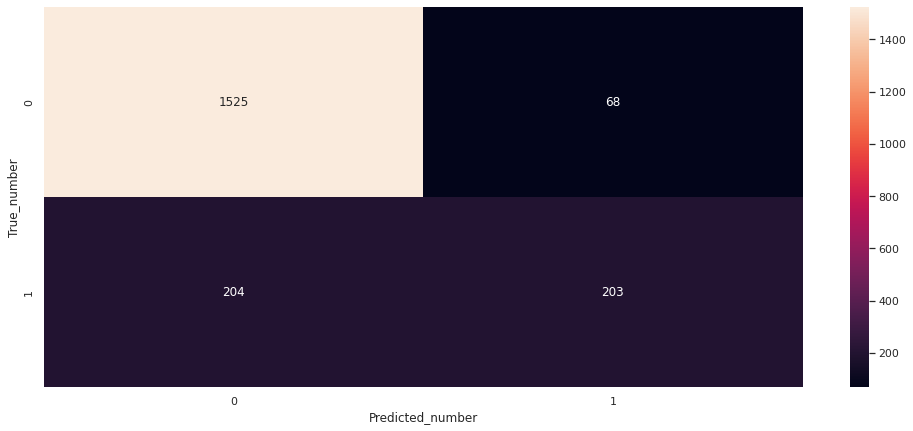

In [151]:
# Model 6 - print classification_report
print(classification_report(y_test,ypred_list_6))

# Model 6 - ploting the confusion metrix plot
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=ypred_list_6)
plt.figure(figsize = (17,7))
sbn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

## Tuning with the Keras Tuner

In this section tuning will be performed with the Keras tuner. This should result in the best possible accuracy model.

### Hypermodel 1

In [174]:
# Function for building the model
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], 1)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 1-512
  hp_units = hp.Int('units', min_value=1, max_value=512, step=3)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(3))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

### Instantiate the tuner and perform hypertuning

In [175]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='google_drive',
                     project_name='churn_kt')

INFO:tensorflow:Reloading Oracle from existing project google_drive/churn_kt/oracle.json
INFO:tensorflow:Reloading Tuner from google_drive/churn_kt/tuner0.json


In [176]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [177]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.01.



In [178]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_7 = tuner.hypermodel.build(best_hps)
history_7 = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

val_acc_per_epoch = history_7.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2570 - accuracy: 0.8933 - val_loss: 0.4683 - val_accuracy: 0.8275
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.8883 - val_loss: 0.4675 - val_accuracy: 0.8406
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2634 - accuracy: 0.8877 - val_loss: 0.4509 - val_accuracy: 0.8469
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8959 - val_loss: 0.4828 - val_accuracy: 0.8431
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2614 - accuracy: 0.8898 - val_loss: 0.4806 - val_accuracy: 0.8306
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.8928 - val_loss: 0.4621 - val_accuracy: 0.8469
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.8919 - val_loss: 0.4593 - val_accuracy: 0.8413

In [179]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_8 = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/43
200/200 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.8270 - val_loss: 0.3612 - val_accuracy: 0.8637
Epoch 2/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3630 - accuracy: 0.8516 - val_loss: 0.3662 - val_accuracy: 0.8494
Epoch 3/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.8517 - val_loss: 0.3843 - val_accuracy: 0.8450
Epoch 4/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3529 - accuracy: 0.8552 - val_loss: 0.3473 - val_accuracy: 0.8531
Epoch 5/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3504 - accuracy: 0.8545 - val_loss: 0.3582 - val_accuracy: 0.8438
Epoch 6/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8569 - val_loss: 0.3499 - val_accuracy: 0.8625
Epoch 7/43
200/200 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8591 - val_loss: 0.3400 - val_accuracy: 0.8594
Epoch 

In [180]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

63/63 [==============================] - 0s 2ms/step - loss: 0.3775 - accuracy: 0.8535
[test loss, test accuracy]: [0.3774605691432953, 0.8535000085830688]


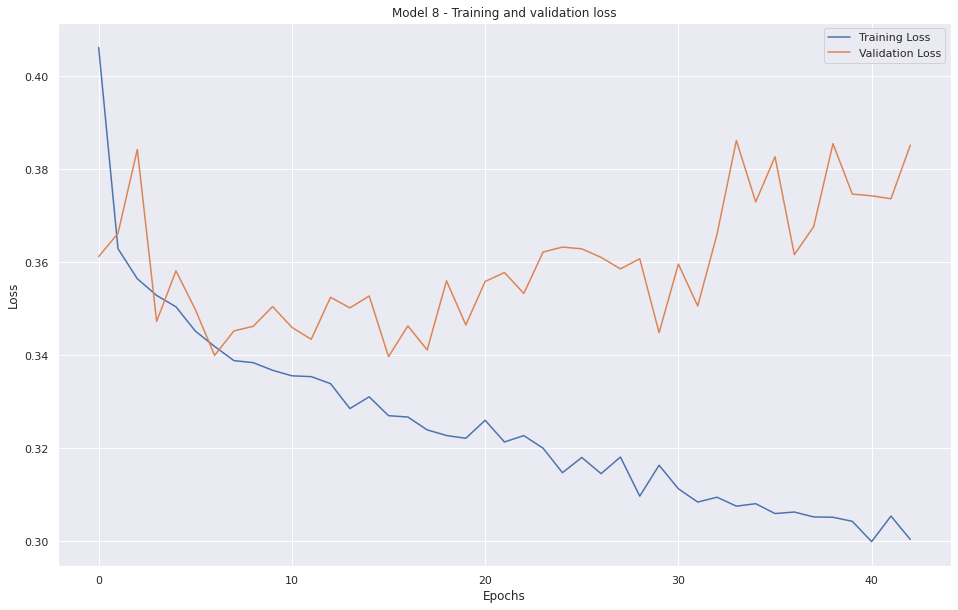

In [183]:
# Hypermodel 1 - Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history_8.history['loss'], label = 'Training Loss')
plt.plot(history_8.history['val_loss'], label = 'Validation Loss')
plt.title('Hypermodel 1 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

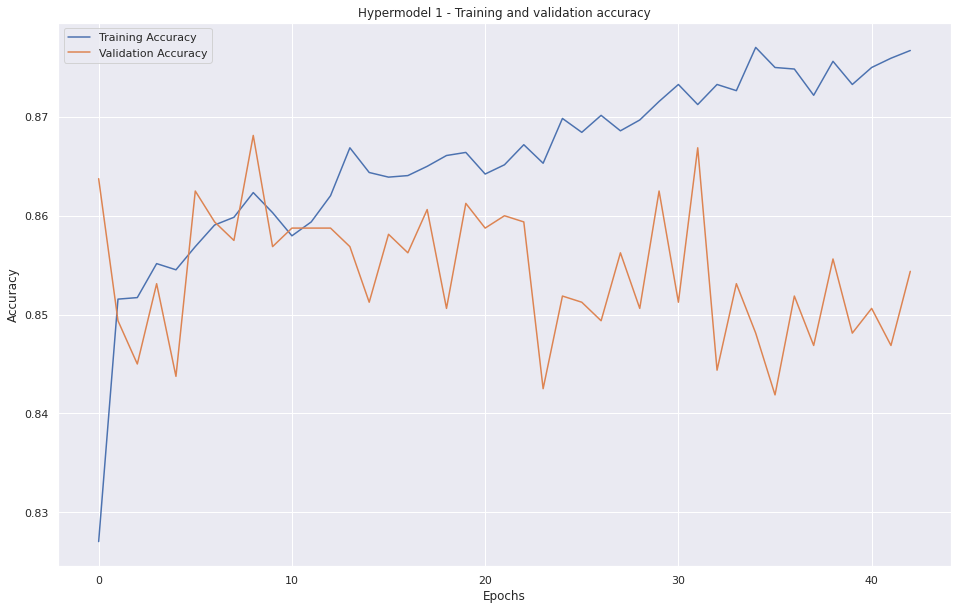

In [184]:
# Hypermodel 1 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_8.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_8.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Hypermodel 1 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Hypermodel 2

In [185]:
tuner_2 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='google_drive',
                     project_name='churn_kt')

INFO:tensorflow:Reloading Oracle from existing project google_drive/churn_kt/oracle.json
INFO:tensorflow:Reloading Tuner from google_drive/churn_kt/tuner0.json


In [186]:
stop_early_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [187]:
tuner_2.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early_2])

# Get the optimal hyperparameters
best_hps_2=tuner_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_2.get('units')} and the optimal learning rate for the optimizer
is {best_hps_2.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.01.



In [188]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_7 = tuner_2.hypermodel.build(best_hps_2)
history_9 = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

val_acc_per_epoch_2 = history_9.history['val_accuracy']
best_epoch_2 = val_acc_per_epoch_2.index(max(val_acc_per_epoch_2)) + 1
print('Best epoch: %d' % (best_epoch_2,))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2463 - accuracy: 0.8945 - val_loss: 0.5012 - val_accuracy: 0.8363
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.8939 - val_loss: 0.5279 - val_accuracy: 0.8363
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2454 - accuracy: 0.8947 - val_loss: 0.5148 - val_accuracy: 0.8244
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2411 - accuracy: 0.8975 - val_loss: 0.5179 - val_accuracy: 0.8313
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2439 - accuracy: 0.8977 - val_loss: 0.5164 - val_accuracy: 0.8419
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.8950 - val_loss: 0.5324 - val_accuracy: 0.8394
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2478 - accuracy: 0.8925 - val_loss: 0.5367 - val_accuracy: 0.8238

In [189]:
hypermodel_2 = tuner_2.hypermodel.build(best_hps_2)

# Retrain the model
history_10 = hypermodel_2.fit(X_train, y_train, epochs=best_epoch_2, validation_split=0.2)

Epoch 1/58
200/200 [==============================] - 1s 3ms/step - loss: 0.4160 - accuracy: 0.8266 - val_loss: 0.4084 - val_accuracy: 0.8388
Epoch 2/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8456 - val_loss: 0.3580 - val_accuracy: 0.8569
Epoch 3/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8536 - val_loss: 0.3710 - val_accuracy: 0.8562
Epoch 4/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8541 - val_loss: 0.3644 - val_accuracy: 0.8587
Epoch 5/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8580 - val_loss: 0.3726 - val_accuracy: 0.8431
Epoch 6/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8584 - val_loss: 0.3456 - val_accuracy: 0.8575
Epoch 7/58
200/200 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8534 - val_loss: 0.3412 - val_accuracy: 0.8581
Epoch 

In [190]:
eval_result_2 = hypermodel_2.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result_2)

63/63 [==============================] - 0s 2ms/step - loss: 0.3731 - accuracy: 0.8485
[test loss, test accuracy]: [0.37308305501937866, 0.8485000133514404]


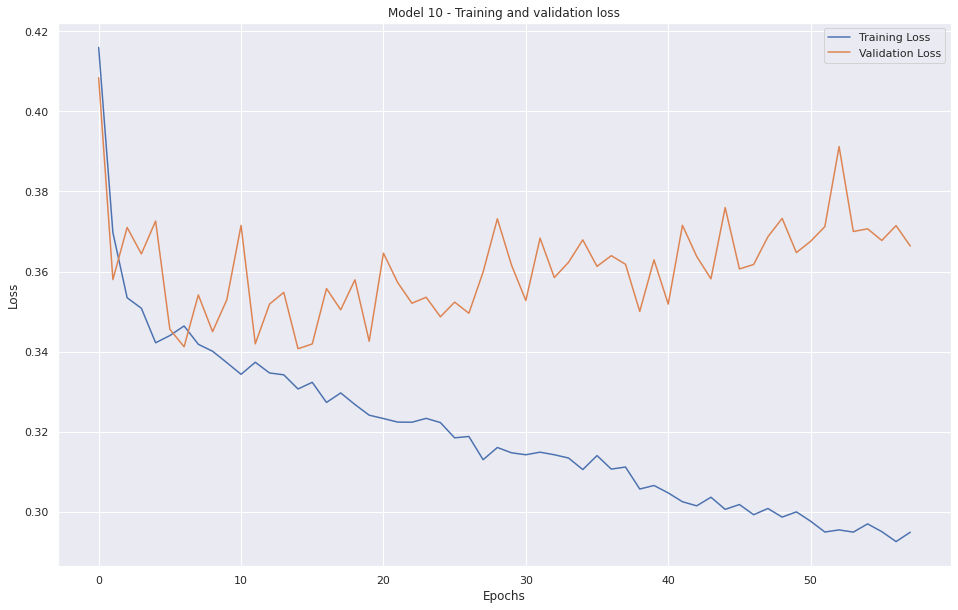

In [191]:
# Hypermodel 2 - Training and Validation Loss (loss vs epochs)
plt.clf()
plt.plot(history_10.history['loss'], label = 'Training Loss')
plt.plot(history_10.history['val_loss'], label = 'Validation Loss')
plt.title('Model 10 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

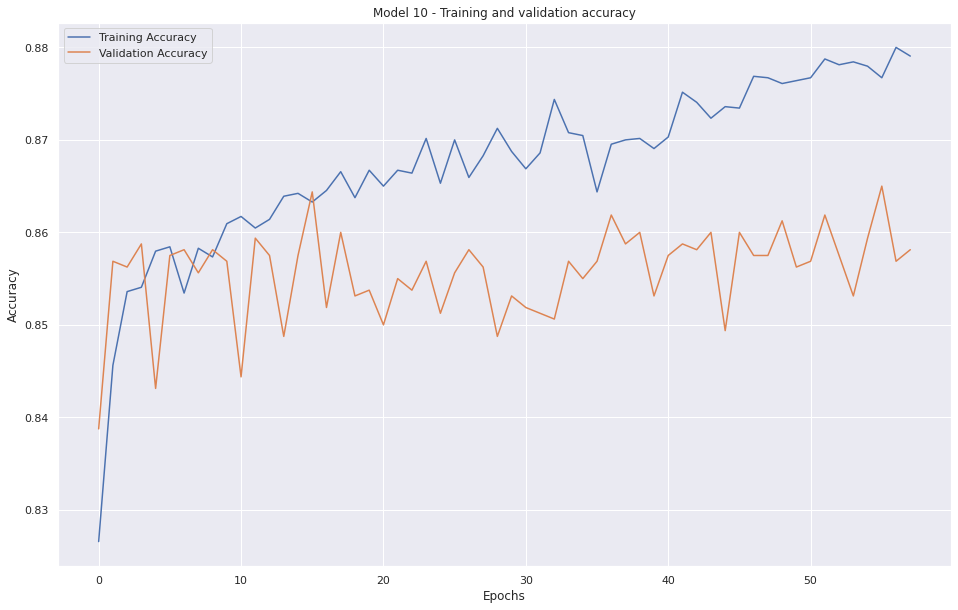

In [192]:
# Hypermodel 2 - Training and Validation Accuracy (accuracy vs epochs)
plt.clf()
plt.plot(history_10.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_10.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 10 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusions and Takeaways

- Customers in Germany are more likely to churn than the other countries.
- Credit Score is a strong predictor of churn - customers with lower credit scores are more likely to churn with the lowest scores highly likely to churn.
- Customers with two products are less likely to churn. Customers with more than two products have the highest likelihood of churn.
- Statistical analysis shows us that the younger the customer, the more likely they are to churn. Apparently the banking products do not meet the requirements of younger customers for some reason.
- The conclusion to draw is that it is possible to build a model with an accuracy ~86% but not much greater due to the noise in the model. Although I was getting the same result with a low number of neurons, the keras tuner selected 288 in the hidden layer - which is surprising. The simpler model with less epochs was shown to be fairly accurate - so I would deploy the simpler model in this case in order to predict churn.
- Ultimately, it is not known from this project what the root cause of churn is - perhaps research into why younger female customers with low credit and more products are leaving teh bank might reach some conclusions. The bank should also examine why Germany generally has a higher rate of churn than other countries.

## Model Evaluations
- Model 1 achieves an accuracy on test data of ~85% using the least resources of any of the models - This model shows that even the simplest of models performs rather well.
- Model 2 achieves a slightly higher accuracy and is still also resource friendly. It has an accuracy of ~86% and does not use much resources.
- Model 3 achieved a recall of 97% which is impressive.
- Model 4 achieved an accuracy of 86% and recall of 98% - the best model so far.
- Model 5 achieved a result of 86% and recall of 96%
- Model 6 also had an accuracy of ~86% and recall of 96%
- Keras Tuned Model 1 has an accuracy of 85%
- Keras Tuned Model 2 has an accuracy of 86%

The highest accuracy possible from the models is 86% with the highest recall of 98%. Model 4 has the best performance scores and is a less resource-intensive model than the keras tuned models. Model 4 should be applied for predicting churn based on the sample data recieved.